In [19]:
from ultralytics import YOLO
import google.generativeai as genai
from dotenv import load_dotenv
import os
import time
import tqdm
import json

load_dotenv()

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel('gemini-1.5-flash')

In [114]:
img_root = r"C:\Users\hoang\OneDrive\Desktop\nghich_prj\Hackathon\Hack-CMC-Heineken\data\387792437_1499962164179099_5036152900747385591_n.jpg"

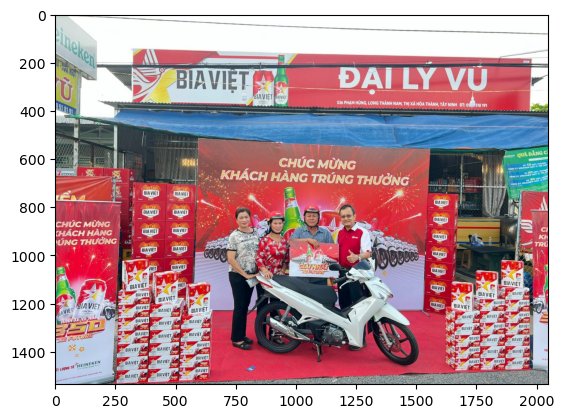

In [124]:
from PIL import Image
import matplotlib.pyplot as plt

img_pil = Image.open(img_root).convert("RGB")
plt.imshow(img_pil)
plt.show()

In [115]:
PROMPT_EN = """
You are given an image related to Heineken beer products and various activities to enhance their service quality in customer experience.
The images may depict grocery stores with Heineken products, street activities by Heineken staff, bars, pubs, restaurants, special events like gameshows, and more.
Analyze each image and provide the following information:

- context: The place context in the image. For examples: bar, restaurant, grocery store, supermarket, small pub,... Just return me the place, not explain or say any un need words
- activity: list of short keyword describe human activities happend in image
- emotion: list of the main emotion of people in the image 
- effectiveness: If there are activities to enhance the user experience for example event, enjoy product..., i want to know how success, efficiency it be or whether it need to be improved, how to improve in short

Ensure the values are short, informative, and useful for further statistical analysis. If any of the criteria do not apply to the image, return null value for that key.
Format the response in JSON

**Example response:**
{
  "context": "bar"
  "activity": ["drinking", "eating"],
  "emotion": ["happy", "enjoyable"],
  "effectiveness": null,
}
{
  "context": "street"
  "activity": ["beer promotion", "play game"],
  "emotion": ["happy", "interested"],
  "effectiveness": "highly effective",
}
{
  "context": "grocery store",
  "activity": null,
  "emotion": null,
  "effectiveness": null
}

"""

## Model detect context, emotions

In [116]:
def get_response(img_path):
    sample_file = genai.upload_file(path=img_path,
                            display_name="Image")

    response = model.generate_content([sample_file, PROMPT_EN])
    return response.text

In [117]:
res_llm = get_response(img_root).replace("\n ", "").replace("\n", "").replace("```json", "").replace("```", "")
res_llm

'{ "context": "grocery store", "activity": ["promotion", "give away"], "emotion": ["happy", "excited"], "effectiveness": "highly effective"}'

In [118]:
def replace_nulls(obj):
    if isinstance(obj, list) and len(obj or []) == 1 and obj[0] == "null":
        return None
    elif isinstance(obj, list):
        return [replace_nulls(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: replace_nulls(value) for key, value in obj.items()}
    elif isinstance(obj, str) and obj == "null":
        return None
    return obj            
def parse_llm_res(res):
    json_res = json.loads(res)
    return replace_nulls(json_res)

In [119]:
res_llm = parse_llm_res(res_llm)
res_llm

{'context': 'grocery store',
 'activity': ['promotion', 'give away'],
 'emotion': ['happy', 'excited'],
 'effectiveness': 'highly effective'}

## Model detect human

In [121]:
import torch
def obj_counting(arr, names):
    unique_elements, counts = torch.unique(arr, return_counts=True)
    # Display the results
    for element, count in zip(unique_elements, counts):
        class_name = names[int(element)]
        print(f"Element {class_name} appears {count} times")

In [122]:
human_detection = YOLO(r"C:\Users\hoang\OneDrive\Desktop\nghich_prj\Hackathon\Hack-CMC-Heineken\weights\v8m_human_detection\best.pt")
human_classes = human_detection.names

In [123]:
human_results = human_detection(img_root)[0].boxes.cls
obj_counting(human_results, human_classes)


image 1/1 C:\Users\hoang\OneDrive\Desktop\nghich_prj\Hackathon\Hack-CMC-Heineken\data\387792437_1499962164179099_5036152900747385591_n.jpg: 480x640 1 waiter, 3 guests, 2050.0ms
Speed: 16.7ms preprocess, 2050.0ms inference, 17.0ms postprocess per image at shape (1, 3, 480, 640)
Element waiter appears 1 times
Element guest appears 3 times


## Model detect avertise